## Index
1. [Model1](#model1)
2. [Model2](#model2) - take into account groups 
    3. [Model3](#model3) - random relu/BN 
        3. [Model6](#model6) - additive model on Model3
4. [Model4](#model4) - not work
5. [Model5](#model5) - not work
6. [Prediction](#predict) 

In [30]:
%matplotlib inline
import theano
import theano.tensor as tt
import numpy as np
import pandas as pd
import cPickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer ,rrelu, batch_norm
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax
import lasagne.layers as layers
import lasagne
from skimage.filters import sobel, laplace
import copy
from skimage.util import pad,crop
from lasagne.updates import adam
from GBM import GBM
from sklearn.tree import ExtraTreeRegressor

In [556]:
with open(r"/home/will/Desktop/data/Facial Keypoints Detection/y_train.pkl", "rb") as output_file:
    y_train=cPickle.load(output_file)
with open(r"/home/will/Desktop/data/Facial Keypoints Detection/X_train.pkl", "rb") as output_file:
    X_train=cPickle.load(output_file)
with open(r"/home/will/Desktop/data/Facial Keypoints Detection/X_feature.pkl", "rb") as output_file:
    X_feature=cPickle.load(output_file)

In [343]:
data = pd.read_csv(r'/home/will/Desktop/data/Facial Keypoints Detection/training.csv')

In [344]:
X_train = data.Image.str.split(expand=True).values.astype('float32')

In [345]:
n = X_train.shape[0]

In [346]:
scaler = StandardScaler()
X_train_raw = scaler.fit_transform(X_train).reshape(n,1,96,96)

In [347]:
X_train = np.broadcast_to(X_train_raw , (n,3,96,96))

In [348]:
y_train = data.loc[:,'left_eye_center_x':'mouth_center_bottom_lip_y'].values.astype('float32')

In [349]:
del data

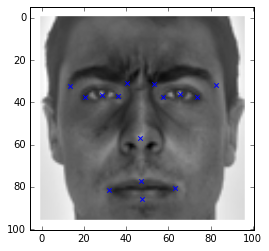

In [350]:
plt.imshow(X_train[1350,0],cmap='gray')
plt.scatter(y_train[1350,0::2],y_train[1350,1::2],marker='x')

In [10]:
y_train.shape

(7049, 30)

In [11]:
X_train.shape

(7049, 3, 96, 96)

In [12]:
np.isnan(X_train).sum(0).max()

0

In [13]:
np.isnan(y_train).sum(0)

array([  10,   10,   13,   13, 4778, 4778, 4782, 4782, 4781, 4781, 4781,
       4781, 4779, 4779, 4824, 4824, 4779, 4779, 4813, 4813,    0,    0,
       4780, 4780, 4779, 4779, 4774, 4774,   33,   33])

In [351]:
min_max = np.c_[ np.floor(np.nanmin(y_train,0)), np.ceil(np.nanmax(y_train,0))]

In [352]:
min_max

array([[ 22.,  95.],
       [  1.,  81.],
       [  0.,  86.],
       [  4.,  82.],
       [ 19.,  85.],
       [ 27.,  67.],
       [ 27.,  96.],
       [ 26.,  65.],
       [  5.,  71.],
       [ 26.,  70.],
       [  3.,  62.],
       [ 25.,  71.],
       [ 17.,  80.],
       [ 15.,  61.],
       [ 32.,  95.],
       [ 10.,  61.],
       [  6.,  77.],
       [ 16.,  63.],
       [  3.,  59.],
       [ 13.,  67.],
       [ 12.,  90.],
       [ 17.,  96.],
       [ 22.,  85.],
       [ 57.,  95.],
       [  2.,  75.],
       [ 56.,  96.],
       [ 12.,  84.],
       [ 56.,  95.],
       [ 12.,  90.],
       [ 25.,  96.]], dtype=float32)

In [353]:
def batch_predict(fun,X,batch_size):
    n = X.shape[0]
    y = np.zeros((n,30))

    for i in range(int(np.ceil(n/batch_size*1.0))):
        y[i * batch_size: min(n,(i + 1) * batch_size)] = \
            fun(X[i * batch_size: min(n,(i + 1) * batch_size)])
    
    return y

def batch_cum(fun,X,y,batch_size):
    n = X.shape[0]
    cost = 0.0

    for i in range(int(np.ceil(n/batch_size*1.0))):
        cost += fun(X[i * batch_size: min(n,(i + 1) * batch_size)],\
                 y[i * batch_size: min(n,(i + 1) * batch_size)])
    
    return cost

def batch_cum2(fun,X,y,group,batch_size):
    n = X.shape[0]
    cost = 0.0

    for i in range(int(np.ceil(1.0*n/batch_size))):
        cost += fun(X[i * batch_size: min(n,(i + 1) * batch_size)],\
                    y[i * batch_size: min(n,(i + 1) * batch_size)],\
                    group[i * batch_size: min(n,(i + 1) * batch_size)])
    
    return cost

def batch_cum3(fun,X,y,group,batch_size):
    n = X.shape[0]
    cost = 0.0

    for i in range(int(np.ceil(1.0*n/batch_size))):
        cost += fun(X[i * batch_size: min(n,(i + 1) * batch_size)],\
                    y[i * batch_size: min(n,(i + 1) * batch_size)],\
                    group)
    
    return cost

** analysis on target variable missing **

Training dataset target

In [354]:
train_target_set = dict()
for row in np.isnan(y_train):
    temp = tuple(np.arange(30)[~row])
    if temp in train_target_set:
        train_target_set[temp]+=1
    else:
        train_target_set[temp]=1

In [355]:
summ = 0
for key,item in train_target_set.iteritems():
    if item > 100:
        print key,item

(0, 1, 2, 3, 20, 21, 28, 29) 4755
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29) 2140


In [356]:
4755/2140.0

2.22196261682243

Create class label for the two distinct group of target variables

In [357]:
group_label = np.zeros((y_train.shape[0]))
for i,row in enumerate(np.isnan(y_train)):
    if tuple(np.arange(30)[~row]) == (0, 1, 2, 3, 20, 21, 28, 29):
        group_label[i] = 1.0

In [358]:
group_label.sum()

4755.0

In [359]:
group_label = group_label.astype('float32').reshape(-1,1)

Testing dataset target 

In [360]:
IdLookupTable = pd.read_csv(r'/home/will/Desktop/data/Facial Keypoints Detection/IdLookupTable.csv')

In [361]:
FeatureName = "left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip"

In [362]:
FeatureToNum = {feature:i for i,feature in enumerate(FeatureName.replace(' ','').split(','))}

In [363]:
NumToFeature = {i:feature for i,feature in enumerate(FeatureName.replace(' ','').split(','))}

In [364]:
IdLookupTable['FeatureNum']=IdLookupTable.FeatureName.str.replace('_x','')\
                            .str.replace('_y','').map(FeatureToNum)

In [365]:
IdLookupTable

,RowId,ImageId,FeatureName,Location,FeatureNum
0,1,1,left_eye_center_x,NaN,0
1,2,1,left_eye_center_y,NaN,0
2,3,1,right_eye_center_x,NaN,1
3,4,1,right_eye_center_y,NaN,1
4,5,1,left_eye_inner_corner_x,NaN,2
5,6,1,left_eye_inner_corner_y,NaN,2
6,7,1,left_eye_outer_corner_x,NaN,3
7,8,1,left_eye_outer_corner_y,NaN,3
8,9,1,right_eye_inner_corner_x,NaN,4
9,10,1,right_eye_inner_corner_y,NaN,4


In [366]:
FeatureSet = IdLookupTable.groupby('ImageId').apply(lambda x: frozenset(x.FeatureNum)).reset_index()

In [367]:
FeatureSet.groupby(0).count()

,ImageId
0,
"(0, 1, 10)",2
"(6, 7, 8, 9, 10, 11, 12, 13, 14)",1
"(0, 1, 10, 14)",1190
"(0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14)",1
"(0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14)",1
"(0, 1, 3, 4, 5, 10, 11, 12, 13, 14)",1
"(0, 1, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14)",1
"(0, 1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14)",1
"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14)",1


In [368]:
1190/556.0

2.1402877697841727

In [369]:
FeatureSet['group_label'] = (FeatureSet[0] == frozenset((0, 1, 10, 14)))*1.0

In [370]:
group_label_test = FeatureSet['group_label'].values.astype('float32').reshape(-1,1)

In [371]:
FeatureSet

,ImageId,0,group_label
0,1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
1,2,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
2,3,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
3,4,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
4,5,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
5,6,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
6,7,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
7,8,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
8,9,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
9,10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0


** use VGG-16. Pool 3 and before are used as feature extractor with no fine-tuning **

In [2]:
d = cPickle.load(open('/home/will/Desktop/data/Pretrain/vgg16.pkl'))

In [3]:
def build_feature():
    net = {}
    net['input'] = InputLayer((7, 3, 96, 96))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    return net 

def build_model():
    net = {}
    net['input'] = InputLayer((7, 256, 12, 12))
    net['conv4_1'] = ConvLayer(net['input'], 512, 3, pad=1)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=500)
    net['fc7'] = DenseLayer(net['fc6'], num_units=30,nonlinearity=lasagne.nonlinearities.sigmoid)
    return net



In [4]:
net_feature = build_feature()

In [5]:
layers.get_output_shape(net_feature['pool3'])

(7, 256, 12, 12)

In [6]:
lasagne.layers.set_all_param_values(net_feature['pool3'], d['param values'][:14])

In [34]:
layers.get_all_params(net_feature['pool3'],trainable=False)

[]

In [377]:
#lasagne.layers.set_all_param_values(net_model['pool5'], d['param values'][14:26])

In [378]:
del d

In [379]:
X_sym = tt.tensor4()

feature = layers.get_output(net_feature['pool3'], X_sym)

Create feature using feature layers

In [380]:
feature_ext = theano.function([X_sym],feature)

In [381]:
X_feature = np.zeros((n, 256, 12, 12),dtype='float32')
batch_size = 13
for i in range(n/13):
    X_feature[i * batch_size: (i + 1) * batch_size] = \
        feature_ext(X_train[i * batch_size: (i + 1) * batch_size])

In [382]:
feature_mean = X_feature.mean(0)
feature_std = X_feature.std(0)
feature_std = np.where(feature_std==0.0, 1.0,feature_std)

In [383]:
X_feature = (X_feature- feature_mean)/feature_std 

In [47]:
del X_train

<a id='model1'></a>
** Model1 **

In [30]:
net_model = build_model()

In [31]:
X_tt = tt.tensor4()
y_tt = tt.matrix()
learning_rate_tt = tt.scalar()
m_tt = tt.scalar()

In [32]:
yhat_tt = layers.get_output(net_model['fc7'], X_tt) * (min_max[:,1] - min_max[:,0]) + min_max[:,0]

In [33]:
cost = tt.sum(tt.switch(tt.isnan(y_tt), .0, (y_tt - yhat_tt)**2 ))

In [34]:
params = lasagne.layers.get_all_params(net_model['fc7'], trainable=True)
updates = lasagne.updates.nesterov_momentum(
            cost, params, learning_rate=learning_rate_tt, momentum=m_tt)

In [249]:
train_fn = theano.function([X_tt, y_tt,learning_rate_tt,m_tt], cost, updates=updates)

In [143]:
predict  = theano.function([X_tt],yhat_tt)

In [250]:
loss = theano.function([X_tt, y_tt], cost)

In [451]:
#gnorm  = [tt.mean(tt.abs_(g)) for g in gparas]

In [454]:
#from theano.compile.nanguardmode import NanGuardMode
#train_val = theano.function([X_tt], layers.get_output(net_model['fc7'], X_tt))
                           #mode=NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=True))

In [36]:
epoch = 10
mv = 0.9
err = 0 

for i in range(epoch):
    for j in range(n/batch_size):
        err = mv * err + (1-mv) * train_fn(X_feature[j * batch_size: (j + 1) * batch_size], \
                                           y_train[j * batch_size: (j + 1) * batch_size],\
                                          1e-6, 0.95)
        

    
    print 'epoch:{}, err:{}'.format(i,err)

epoch:0, err:295.405146276
epoch:1, err:207.38878919
epoch:2, err:170.967799246
epoch:3, err:135.786502752
epoch:4, err:94.1792689796
epoch:5, err:89.4265625978
epoch:6, err:87.3077118365
epoch:7, err:66.6783877725
epoch:8, err:57.3902892885
epoch:9, err:52.6058211211


In [254]:
err = batch_cum(loss,X_feature,y_train,batch_size)

In [263]:
np.sqrt(err/n)

7.5056684788298167

In [264]:
epoch = 5
mv = 0.9

for i in range(epoch):
    for j in range(n/batch_size):
        train_fn(X_feature[j * batch_size: (j + 1) * batch_size], \
                                           y_train[j * batch_size: (j + 1) * batch_size],\
                                          5e-7, 0.95)
    
    err = batch_cum(loss,X_feature,y_train,batch_size)
    
    
    print 'epoch:{}, err:{}'.format(i,np.sqrt(err/n))

epoch:0, err:7.43479862153
epoch:1, err:7.13509097107
epoch:2, err:6.89347770889
epoch:3, err:6.62657195201
epoch:4, err:6.58381387768


In [268]:
with open(r"/home/will/Desktop/data/Facial Keypoints Detection/submit2.pkl", "wb") as output_file:
    cPickle.dump(lasagne.layers.get_all_param_values(net_model['fc7']), output_file)

<a id='model2'></a>
** Model2 - take into account group label **

In [237]:
def build_model2():
    net = {}
    net['input'] = InputLayer((7, 256, 12, 12))
    net['conv4_1'] = ConvLayer(net['input'], 512, 3, pad=1)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    return net

In [238]:
net_model2 = build_model2()

In [239]:
X_tt = tt.tensor4()
y_tt = tt.matrix()
learning_rate_tt = tt.scalar()
m_tt = tt.scalar()

In [240]:
group_tt = tt.col() # group label

In [241]:
combine_tt = tt.concatenate([lasagne.layers.get_output(net_model2['pool5'],X_tt).flatten(2),\
                             group_tt], 1)

In [242]:
W1 = theano.shared((np.random.randn(512*3*3+1, 500)/np.sqrt(512*3*3*2+1)).astype('float32'),\
                  name='W1',borrow=True)

In [243]:
B1 = theano.shared(value=np.zeros((500),dtype='float32'),\
                  name='B1',borrow=True)

In [244]:
X1 = tt.nnet.relu(tt.dot(combine_tt,W1)+B1)

In [245]:
W2 = theano.shared((np.random.randn(501,30)/np.sqrt(501*2)).astype('float32'),\
                  name='W2',borrow=True)

In [246]:
B2 = theano.shared(value=np.zeros((30),dtype='float32'),\
                  name='B2',borrow=True)

In [247]:
X2 = tt.nnet.sigmoid(tt.dot(tt.concatenate([X1,group_tt],1),\
                         W2)+B2)

In [248]:
yhat_tt =  X2 * (min_max[:,1] - min_max[:,0]) + min_max[:,0]

In [249]:
cost = tt.sum(tt.switch(tt.isnan(y_tt), .0, (y_tt - yhat_tt)**2 ))

In [250]:
paras = lasagne.layers.get_all_params(net_model2['pool5'], trainable=True) + [W1,B1,W2,B2]

In [251]:
gparas = [tt.grad(cost,para) for para in paras]
vparas = [theano.shared(np.zeros(para.get_value().shape,dtype='float32')) for para in paras]

In [252]:
updates=[]
for p,g,v in zip(paras,gparas,vparas):
    updates.append((v,m_tt*v - learning_rate_tt*g))
    updates.append((p,p+m_tt*m_tt*v-(1+m_tt)*learning_rate_tt*g))

In [253]:
#updates = lasagne.updates.nesterov_momentum(
#            cost, paras, learning_rate=learning_rate_tt, momentum=m_tt)

In [254]:
train_fn = theano.function([X_tt, y_tt,group_tt,learning_rate_tt,m_tt], cost, updates=updates)

In [255]:
predict  = theano.function([X_tt,group_tt],yhat_tt)

In [256]:
loss = theano.function([X_tt, y_tt,group_tt], cost)

In [407]:
#gnorm  = [tt.mean(tt.abs_(g)) for g in gparas]

In [408]:
#from theano.compile.nanguardmode import NanGuardMode
#train_val = theano.function([X_tt], layers.get_output(net_model['fc7'], X_tt))
                           #mode=NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=True))

In [257]:
epoch = 10

for i in range(epoch):
    for j in range(n/batch_size):
        train_fn(X_feature[j * batch_size: (j + 1) * batch_size], \
                 y_train[j * batch_size: (j + 1) * batch_size],\
                 group_label[j * batch_size: (j + 1) * batch_size],\
                 1e-6, 0.95)
        

    
    err = batch_cum2(loss,X_feature,y_train,group_label,batch_size)
    
    
    print 'epoch:{}, err:{}'.format(i,np.sqrt(err/n))

epoch:0, err:14.2363006856
epoch:1, err:11.7987414985
epoch:2, err:10.8293530619
epoch:3, err:9.83119623779
epoch:4, err:9.41422722098
epoch:5, err:8.58274544781
epoch:6, err:7.67632226687
epoch:7, err:7.63067023423
epoch:8, err:7.21883050857
epoch:9, err:7.47844163669


In [259]:
epoch = 5

for i in range(epoch):
    for j in range(n/batch_size):
        train_fn(X_feature[j * batch_size: (j + 1) * batch_size], \
                 y_train[j * batch_size: (j + 1) * batch_size],\
                 group_label[j * batch_size: (j + 1) * batch_size],\
                 1e-7, 0.95)
        

    
    err = batch_cum2(loss,X_feature,y_train,group_label,batch_size)
    
    
    print 'epoch:{}, err:{}'.format(i,np.sqrt(err/n))

epoch:0, err:5.0818250469
epoch:1, err:4.84769410699
epoch:2, err:4.71234620385
epoch:3, err:4.61551174948
epoch:4, err:4.53708666642


In [277]:
with open(r"/home/will/Desktop/data/Facial Keypoints Detection/submit3.pkl", "wb") as output_file:
    cPickle.dump([p.get_value() for p in paras], output_file)

<a id='model3'></a>
** Model3 - RRelu to model2 **

In [562]:
def build_model3():
    net = {}
    net['input'] = InputLayer((batch_size, 256, 12, 12))
    net['conv4_1'] = rrelu(ConvLayer(net['input'], 512, 3, pad=1))
    net['conv4_2'] = rrelu(ConvLayer(net['conv4_1'], 512, 3, pad=1))
    net['conv4_3'] = rrelu(ConvLayer(net['conv4_2'], 512, 3, pad=1))
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = rrelu(ConvLayer(net['pool4'], 512, 3, pad=1))
    net['conv5_2'] = rrelu(ConvLayer(net['conv5_1'], 512, 3, pad=1))
    net['conv5_3'] = rrelu(ConvLayer(net['conv5_2'], 512, 3, pad=1))
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    return net

In [812]:
# with batch norm
#def build_model3():
    net = {}
    net['input'] = InputLayer((batch_size, 256, 12, 12))
    net['conv4_1'] = batch_norm(ConvLayer(net['input'], 512, 3, pad=1))
    net['conv4_2'] = batch_norm(ConvLayer(net['conv4_1'], 512, 3, pad=1))
    net['conv4_3'] = batch_norm(ConvLayer(net['conv4_2'], 512, 3, pad=1))
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = batch_norm(ConvLayer(net['pool4'], 512, 3, pad=1))
    net['conv5_2'] = batch_norm(ConvLayer(net['conv5_1'], 512, 3, pad=1))
    net['conv5_3'] = batch_norm(ConvLayer(net['conv5_2'], 512, 3, pad=1))
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    return net

In [734]:
net_model2 = build_model3()

In [735]:
X_tt = tt.tensor4()
y_tt = tt.matrix()
learning_rate_tt = tt.scalar()
m_tt = tt.scalar()

In [736]:
group_tt = tt.col() # group label

In [737]:
combine_tt = tt.concatenate([lasagne.layers.get_output(net_model2['pool5'],X_tt).flatten(2),\
                             group_tt], 1)

In [738]:
W1 = theano.shared((np.random.randn(512*3*3+1, 500)/np.sqrt(512*3*3*2+1)).astype('float32'),\
                  name='W1',borrow=True)

In [739]:
B1 = theano.shared(value=np.zeros((500),dtype='float32'),\
                  name='B1',borrow=True)

In [740]:
X1 = tt.nnet.relu(tt.dot(combine_tt,W1)+B1,0.5)

In [741]:
W2 = theano.shared((np.random.randn(501,30)/np.sqrt(501*2)).astype('float32'),\
                  name='W2',borrow=True)

In [742]:
B2 = theano.shared(value=np.zeros((30),dtype='float32'),\
                  name='B2',borrow=True)

In [743]:
X2 = tt.nnet.sigmoid(tt.dot(tt.concatenate([X1,group_tt],1),\
                         W2)+B2)

In [744]:
yhat_tt =  X2 * (min_max[:,1] - min_max[:,0]) + min_max[:,0]

In [745]:
cost = tt.sum(tt.switch(tt.isnan(y_tt), .0, (y_tt - yhat_tt)**2 ))

In [746]:
paras = lasagne.layers.get_all_params(net_model2['pool5'], trainable=True) + [W1,B1,W2,B2]

In [747]:
#updates = adam(cost, paras, learning_rate=learning_rate_tt)

In [748]:
gparas = [tt.grad(cost,para) for para in paras]
vparas = [theano.shared(np.zeros(para.get_value().shape,dtype='float32')) for para in paras]
updates=[]
for p,g,v in zip(paras,gparas,vparas):
    updates.append((v,m_tt*v - learning_rate_tt*g))
    updates.append((p,p+m_tt*m_tt*v-(1+m_tt)*learning_rate_tt*g))

In [749]:
#updates = lasagne.updates.nesterov_momentum(
#            cost, paras, learning_rate=learning_rate_tt, momentum=m_tt)

In [750]:
train_fn = theano.function([X_tt, y_tt,group_tt,learning_rate_tt,m_tt], cost, updates=updates)

In [751]:
predict  = theano.function([X_tt,group_tt],yhat_tt)

In [752]:
loss = theano.function([X_tt, y_tt,group_tt], cost)

In [753]:
#gnorm  = [tt.mean(tt.abs_(g)) for g in gparas]

In [754]:
#from theano.compile.nanguardmode import NanGuardMode
#train_val = theano.function([X_tt], layers.get_output(net_model['fc7'], X_tt))
                           #mode=NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=True))

In [771]:
# final results with rrelu
epoch = 6
batch_size = 13

for i in range(epoch):
    for j in range(n/batch_size):
        train_fn(X_feature[j * batch_size: (j + 1) * batch_size], \
                 y_train[j * batch_size: (j + 1) * batch_size],\
                 group_label[j * batch_size: (j + 1) * batch_size],\
                 1e-9,0.95)
        

    
    err = batch_cum2(loss,X_feature,y_train,group_label,batch_size)
    
    
    print 'epoch:{}, err:{}'.format(i,np.sqrt(err/n))

epoch:0, err:1.812936558
epoch:1, err:1.81775903806
epoch:2, err:1.82127911206
epoch:3, err:1.81616336645
epoch:4, err:1.81180704362
epoch:5, err:1.81220178328


In [772]:
with open(r"/home/will/Desktop/data/Facial Keypoints Detection/model3.pkl", "wb") as output_file:
    cPickle.dump([p.get_value() for p in paras], output_file)

Understand the model residual

In [776]:
yhat_np = np.zeros_like(y_train)
for i in range(10):
    for j in range(n/batch_size):
        yhat_np[j * batch_size: (j + 1) * batch_size] += \
              predict(X_feature[j * batch_size: (j + 1) * batch_size],\
                      group_label[j * batch_size: (j + 1) * batch_size])  

yhat_np /= 10.0

In [953]:
res = y_train - yhat_np

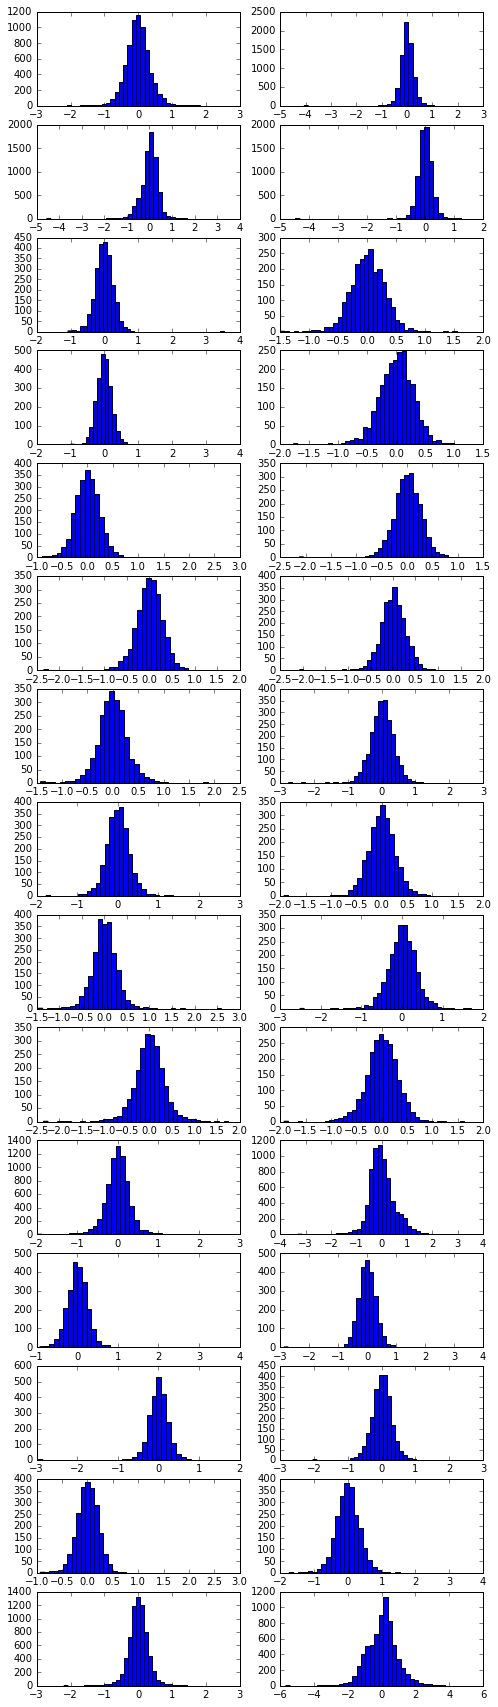

In [778]:
fig, axs = plt.subplots(15,2, figsize=(8, 30))
axs = axs.ravel()
    
for i in range(30):
    axs[i].hist(res[~np.isnan(y_train[:,i]),i],bins=40)


In [955]:
res_dist = np.nanmean(res**2, 1)

In [780]:
np.nansum(res**2, 0).reshape(-1,2)

array([[  997.90240479,   508.30352783],
       [ 1004.36401367,   441.10723877],
       [  158.01571655,   189.75146484],
       [  133.02278137,   204.7134552 ],
       [  131.56077576,   160.13566589],
       [  199.19573975,   185.14772034],
       [  222.64369202,   290.21417236],
       [  197.63261414,   165.91183472],
       [  181.75692749,   288.24423218],
       [  254.27127075,   208.46388245],
       [  685.6161499 ,  2051.57421875],
       [  152.12539673,   217.33349609],
       [  132.99919128,   204.38334656],
       [  108.86690521,   308.8510437 ],
       [  766.03320312,  6067.47998047]], dtype=float32)

In [956]:
res_dist.max()

4.4021096

In [957]:
res_dist.mean()

0.11995357

In [981]:
big_err_index = res_dist>2.5

In [982]:
big_err_index.sum()

11

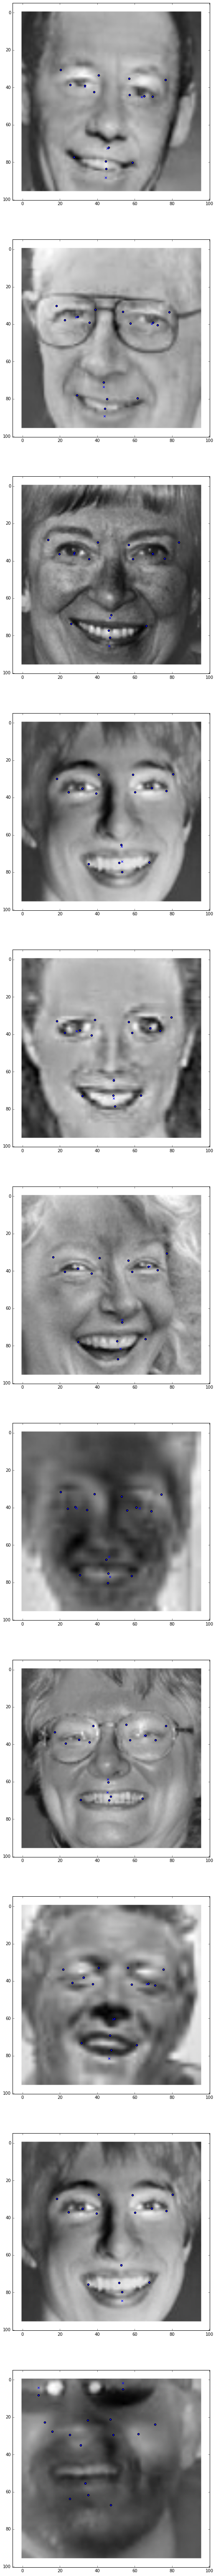

In [983]:
fig, axs = plt.subplots(big_err_index.sum(),1, figsize=(10, big_err_index.sum()*10))
axs = axs.ravel()
    
for i in range(big_err_index.sum()):
    axs[i].imshow(X_train[big_err_index][i],cmap='gray')
    axs[i].scatter(y_train[big_err_index,0::2][i],y_train[big_err_index,1::2][i],marker='x')
    axs[i].scatter(yhat_np[big_err_index,0::2][i],yhat_np[big_err_index,1::2][i],marker='o')

Some image are "mis-labeled". Remove from dataset

In [405]:
delete_index = np.arange(n)[big_err_index][1:]

In [407]:
y_train = np.delete(y_train,delete_index, 0)

In [409]:
X_train = np.delete(X_train,delete_index, 0)

In [412]:
X_feature = np.delete(X_feature,delete_index, 0)

In [413]:
n = y_train.shape[0]

In [414]:
primes(n)

[2, 13, 271]

In [415]:
batch_size = 13

In [418]:
with open(r"/home/will/Desktop/data/Facial Keypoints Detection/y_train.pkl", "wb") as output_file:
    cPickle.dump(y_train, output_file)
with open(r"/home/will/Desktop/data/Facial Keypoints Detection/X_train.pkl", "wb") as output_file:
    cPickle.dump(X_train, output_file)
with open(r"/home/will/Desktop/data/Facial Keypoints Detection/X_feature.pkl", "wb") as output_file:
    cPickle.dump(X_feature, output_file)

In [421]:
# train with "new" dataset
epoch = 2

for i in range(epoch):
    for j in range(n/batch_size):
        train_fn(X_feature[j * batch_size: (j + 1) * batch_size], \
                 y_train[j * batch_size: (j + 1) * batch_size],\
                 group_label[j * batch_size: (j + 1) * batch_size],\
                 1e-9, 0.95)
        

    
    err = batch_cum2(loss,X_feature,y_train,group_label,batch_size)
    
    
    print 'epoch:{}, err:{}'.format(i,np.sqrt(err/n))

epoch:0, err:1.76497157113
epoch:1, err:1.76898334352


Go back to check residual. Check image with large error

X of images have duplicates while targets different

In [985]:
data = pd.read_csv(r'/home/will/Desktop/data/Facial Keypoints Detection/training.csv')

In [986]:
X_train2 = data.Image.str.split(expand=True).values.astype('uint8')

In [987]:
y_train2 = data.loc[:,'left_eye_center_x':'mouth_center_bottom_lip_y'].values.astype('float32')

In [988]:
X_test = pd.read_csv(r'/home/will/Desktop/data/Facial Keypoints Detection/test.csv')

In [991]:
X_test = X_test.Image.str.split(expand=True).values.astype('uint8')

In [1009]:
y_train2.shape

(7049, 30)

In [994]:
X_train2.shape

(7049, 9216)

In [996]:
dist = pairwise_distances(X_train2,X_test)

In [1006]:
train_index, test_index = np.where(dist == 0)

In [1031]:
y_test2 = np.zeros((n_test,30))
index_count = np.zeros((n_test,1))
for i,index in enumerate(test_index):
    y_test2[index] += y_train2[train_index[i]]
    index_count[index] += 1
y_test2 = y_test2/np.where(index_count==0,1,index_count)

In [995]:
from sklearn.metrics import pairwise_distances

In [449]:
dist = pairwise_distances(X_train2)

In [457]:
x_index, y_index = np.where(dist == 0)

In [472]:
tot = set()
rep_list = []
for x,y in zip(x_index,y_index):
    temp = frozenset((x,y))
    if temp in tot or x==y:
        continue
    else:
        tot.add(temp)
        rep_list.append([x,y])

In [474]:
len(rep_list)

575

In [478]:
X_train2.shape

(7049, 9216)

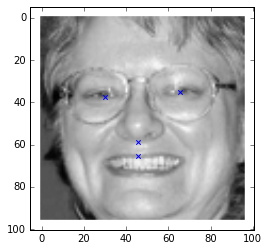

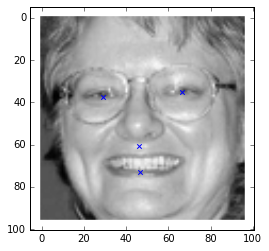

In [501]:
rep_num = 511
num1, num2 = rep_list[rep_num]
plt.imshow(X_train2[num1].reshape(96,96),cmap='gray')
plt.scatter(y_train2[num1,0::2],y_train2[num1,1::2],marker='x')
plt.show()
plt.imshow(X_train2[num2].reshape(96,96),cmap='gray')
plt.scatter(y_train2[num2,0::2],y_train2[num2,1::2],marker='x')
plt.show()

<a id='model6'></a>
** Model6 - additive model on model3 **

In [785]:
X_train = X_train[:,0,:,:]

In [786]:
X_train.shape

(7046, 96, 96)

In [787]:
np.rint(yhat_np[:,-2:])

array([[ 43.,  85.],
       [ 46.,  86.],
       [ 47.,  79.],
       ..., 
       [ 50.,  77.],
       [ 50.,  78.],
       [ 46.,  82.]], dtype=float32)

In [788]:
X_train2 = pad(X_train,((0,0),(7,7),(7,7)),'constant',constant_values=.0)

In [789]:
X_train2.shape

(7046, 110, 110)

In [851]:
X_crop = np.zeros((n,14*14))
for i,(x,y) in enumerate(np.rint(yhat_np[:,-2:])):
    X_crop[i,:] = crop(X_train2[i],((y,96-y),(x,96-x))).reshape(14*14)

In [868]:
X_crop = np.zeros((n,14*14))
for i,(x,y) in enumerate(np.rint(yhat_np[:,-10:-8])):
    X_crop[i,:] = crop(X_train2[i],((y,96-y),(x,96-x))).reshape(14*14)

In [884]:
X_crop = np.zeros((n,14*14))
for i,(x,y) in enumerate(np.rint(yhat_np[:,0:2])):
    X_crop[i,:] = crop(X_train2[i],((y,96-y),(x,96-x))).reshape(14*14)

In [899]:
X_crop = np.zeros((n,14*14))
for i,(x,y) in enumerate(np.rint(yhat_np[:,2:4])):
    X_crop[i,:] = crop(X_train2[i],((y,96-y),(x,96-x))).reshape(14*14)

In [900]:
X_crop.shape

(7046, 196)

In [901]:
#Y_crop = res[:,-2:]
#Y_crop = res[:,-10:-8]
#Y_crop = res[:,0:2]
Y_crop = res[:,2:4]

In [902]:
missing = np.any(np.isnan(Y_crop),1)

In [903]:
Y_crop2 = Y_crop[~missing]

In [904]:
X_crop2 = X_crop[~missing]

In [919]:
index_list = [(-2,None),(-10,-8),(0,2),(2,4)]
add_model_list = [GBM1,GBM2,GBM3,GBM4]

In [905]:
#GBM1 = GBM(ExtraTreeRegressor,500,1e-2,90,{'max_depth':16,'max_features':0.5},2)
#GBM2 = GBM(ExtraTreeRegressor,500,1e-2,90,{'max_depth':16,'max_features':0.5},2)
#GBM3 = GBM(ExtraTreeRegressor,500,1e-2,90,{'max_depth':16,'max_features':0.5},2)
GBM4 = GBM(ExtraTreeRegressor,500,1e-2,90,{'max_depth':16,'max_features':0.5},2)

In [906]:
GBM4.fit(X_crop2,Y_crop2)

GBM(BaseEst=<class 'sklearn.tree.tree.ExtraTreeRegressor'>,
  BasePara={'max_features': 0.5, 'max_depth': 16}, M_est=500, alpha=90,
  learnRate=0.01, subFold=2)

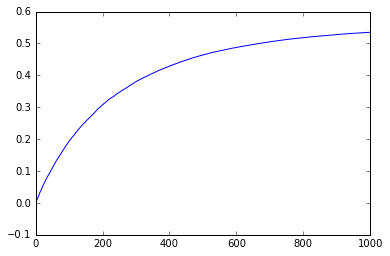

In [908]:
GBM4.plot(X_crop2,Y_crop2,L2_score)

In [909]:
Y_crop_hat = GBM4.predict(X_crop)

In [910]:
yhat_np[:,2:4]+=Y_crop_hat

In [911]:
res = y_train - yhat_np

In [881]:
res_dist = np.nanmean(res**2, 1)

In [863]:
np.nansum(res**2, 0).reshape(-1,2)

array([[  997.90240479,   508.30352783],
       [ 1004.36401367,   441.10723877],
       [  158.01571655,   189.75146484],
       [  133.02278137,   204.7134552 ],
       [  131.56077576,   160.13566589],
       [  199.19573975,   185.14772034],
       [  222.64369202,   290.21417236],
       [  197.63261414,   165.91183472],
       [  181.75692749,   288.24423218],
       [  254.27127075,   208.46388245],
       [  685.6161499 ,  2051.57421875],
       [  152.12539673,   217.33349609],
       [  132.99919128,   204.38334656],
       [  108.86690521,   308.8510437 ],
       [  401.77215576,  2632.96679688]], dtype=float32)

In [882]:
np.nansum(res**2, 0).reshape(-1,2)

array([[  997.90240479,   508.30352783],
       [ 1004.36401367,   441.10723877],
       [  158.01571655,   189.75146484],
       [  133.02278137,   204.7134552 ],
       [  131.56077576,   160.13566589],
       [  199.19573975,   185.14772034],
       [  222.64369202,   290.21417236],
       [  197.63261414,   165.91183472],
       [  181.75692749,   288.24423218],
       [  254.27127075,   208.46388245],
       [  313.64395142,   996.69787598],
       [  152.12539673,   217.33349609],
       [  132.99919128,   204.38334656],
       [  108.86690521,   308.8510437 ],
       [  401.77215576,  2632.96679688]], dtype=float32)

In [897]:
np.nansum(res**2, 0).reshape(-1,2)

array([[  448.15057373,   238.90220642],
       [ 1004.36401367,   441.10723877],
       [  158.01571655,   189.75146484],
       [  133.02278137,   204.7134552 ],
       [  131.56077576,   160.13566589],
       [  199.19573975,   185.14772034],
       [  222.64369202,   290.21417236],
       [  197.63261414,   165.91183472],
       [  181.75692749,   288.24423218],
       [  254.27127075,   208.46388245],
       [  313.64395142,   996.69787598],
       [  152.12539673,   217.33349609],
       [  132.99919128,   204.38334656],
       [  108.86690521,   308.8510437 ],
       [  401.77215576,  2632.96679688]], dtype=float32)

In [912]:
np.nansum(res**2, 0).reshape(-1,2)

array([[  448.15057373,   238.90220642],
       [  485.58898926,   186.2623291 ],
       [  158.01571655,   189.75146484],
       [  133.02278137,   204.7134552 ],
       [  131.56077576,   160.13566589],
       [  199.19573975,   185.14772034],
       [  222.64369202,   290.21417236],
       [  197.63261414,   165.91183472],
       [  181.75692749,   288.24423218],
       [  254.27127075,   208.46388245],
       [  313.64395142,   996.69787598],
       [  152.12539673,   217.33349609],
       [  132.99919128,   204.38334656],
       [  108.86690521,   308.8510437 ],
       [  401.77215576,  2632.96679688]], dtype=float32)

<a id='model4'></a>
** Model4 - RRelu & split structure over groups **

In [641]:
def build_model4():
    net = {}
    net['input'] = InputLayer((7, 256, 12, 12))
    net['conv4_1'] = rrelu(ConvLayer(net['input'], 512, 3, pad=1))
    net['conv4_2'] = rrelu(ConvLayer(net['conv4_1'], 512, 3, pad=1))
    net['conv4_3'] = rrelu(ConvLayer(net['conv4_2'], 512, 3, pad=1))
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = rrelu(ConvLayer(net['pool4'], 512, 3, pad=1))
    net['conv5_2'] = rrelu(ConvLayer(net['conv5_1'], 512, 3, pad=1))
    net['conv5_3'] = rrelu(ConvLayer(net['conv5_2'], 512, 3, pad=1))
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = rrelu(DenseLayer(net['pool5'], num_units=500))
    return net

In [642]:
net_model2 = build_model4()

In [643]:
X_tt = tt.tensor4()
y_tt = tt.matrix()
learning_rate_tt = tt.scalar()
m_tt = tt.scalar()
reg = tt.scalar()
group_tt = tt.scalar() # group label

In [644]:
X1 = lasagne.layers.get_output(net_model2['fc6'],X_tt)

In [645]:
W1 = theano.shared((np.random.randn(500,30)/np.sqrt(500*2)).astype('float32'),\
                  name='W1',borrow=True)

In [646]:
B1 = theano.shared(value=np.zeros((30),dtype='float32'),\
                  name='B1',borrow=True)

In [647]:
W2 = theano.shared(W1.get_value()+(np.random.randn(500,30)/np.sqrt(500*2)).astype('float32'),\
                  name='W2',borrow=True)

In [648]:
B2 = theano.shared(value=np.zeros((30),dtype='float32'),\
                  name='B2',borrow=True)

In [649]:
X2 = tt.nnet.sigmoid(
                    theano.ifelse.ifelse(tt.gt(group_tt,0.5),\
                     tt.dot(X1,W1) + B1,\
                     tt.dot(X1,W2) + B2)
                     )

In [650]:
yhat_tt =  X2 * (min_max[:,1] - min_max[:,0]) + min_max[:,0]

In [651]:
cost = tt.sum(tt.switch(tt.isnan(y_tt), .0, (y_tt - yhat_tt)**2 ))
final_cost = cost + reg * tt.sum((W1-W2)**2)

In [652]:
paras = lasagne.layers.get_all_params(net_model2['fc6'], trainable=True) + [W1,B1,W2,B2]

In [653]:
gparas = [tt.grad(final_cost,para) for para in paras]
vparas = [theano.shared(np.zeros(para.get_value().shape,dtype='float32')) for para in paras]

In [654]:
updates=[]
for p,g,v in zip(paras,gparas,vparas):
    updates.append((v,m_tt*v - learning_rate_tt*g))
    updates.append((p,p+m_tt*m_tt*v-(1+m_tt)*learning_rate_tt*g))

In [655]:
#updates = lasagne.updates.nesterov_momentum(
#            cost, paras, learning_rate=learning_rate_tt, momentum=m_tt)

In [656]:
train_fn = theano.function([X_tt, y_tt,group_tt,learning_rate_tt,m_tt,reg],final_cost ,updates=updates)

In [657]:
predict  = theano.function([X_tt,group_tt],yhat_tt)

In [658]:
loss = theano.function([X_tt, y_tt,group_tt], cost)

In [598]:
p1 = group_label.sum()/ group_label.shape[0]

In [599]:
X_group1 = X_feature[group_label.flatten()==1]
y_group1 = y_train[group_label.flatten()==1]

In [600]:
X_group0 = X_feature[group_label.flatten()==0]
y_group0 = y_train[group_label.flatten()==0]

In [601]:
n_group1 = X_group1.shape[0]
n_group0 = X_group0.shape[0]

In [659]:
epoch = 4
reg_np = 1e2
learningRate_np = 1e-7
mv_np = 0.95

for i in range(epoch):
    for j in range(n/batch_size):
        
        if np.random.rand <= p1: # group1
            index_ = np.random.permutation(n_group1)
            X_group1, y_group1 = X_group1[index_], y_group1[index_]
            
            train_fn(X_group1[0:batch_size], \
                     y_group1[0:batch_size],\
                     1.0,\
                     learningRate_np, mv_np,reg_np)

        else: # group0 
            index_ = np.random.permutation(n_group0)
            X_group0, y_group0 = X_group0[index_], y_group0[index_]
            
            train_fn(X_group0[0:batch_size], \
                     y_group0[0:batch_size],\
                     0.0,\
                     learningRate_np, mv_np,reg_np)
            
    err = batch_cum3(loss,X_group1,y_group1,1.0,batch_size)+\
          batch_cum3(loss,X_group0,y_group0,0.0,batch_size)  
    
    
    print 'epoch:{}, err:{}'.format(i,np.sqrt(err/n))

epoch:0, err:10.9862783839
epoch:1, err:9.58604332939
epoch:2, err:9.15980038362
epoch:3, err:9.1195359187


<a id='model5'></a>
** Model5 - autoencoder on target structure **

In [126]:
d2 = 5

In [127]:
W1 = theano.shared(
            value=np.random.randn(30, d2).astype('float32')/np.sqrt(30*2),
            name='W1',
            borrow=True
        )

W2 = theano.shared(
            value=np.random.randn(d2, 30).astype('float32')/np.sqrt(d2*2),
            name='W2',
            borrow=True
        )

B1 = theano.shared(
            value=np.zeros((d2),dtype='float32'),
            name='B1',
            borrow=True,
            
        )

B2 = theano.shared(
            value=np.zeros((30),dtype='float32'),
            name='B2',
            borrow=True,
            
        )

In [128]:
X0 = tt.matrix()

In [129]:
learning_rate_tt = tt.scalar()
m_tt = tt.scalar()

In [130]:
X0_fill = tt.switch(tt.isnan(X0), np.float32(0), X0)

In [131]:
X1 = tt.dot(X0_fill,W1) + B1

In [132]:
X2 = tt.dot(X1, W2) + B2

In [133]:
cost = tt.sum(tt.switch(tt.isnan(X0),np.float32(0), (X0_fill-X2)**2))

In [134]:
paras = [W1,W2,B1,B2]

In [135]:
vparas = [theano.shared(np.zeros_like(p.get_value(),dtype='float32')) for p in paras]

In [136]:
gparas = tt.grad(cost, paras)

In [137]:
updates=[]
for p,g,v in zip(paras,gparas,vparas):
    updates.append((v,m_tt*v - learning_rate_tt*g))
    updates.append((p,p+m_tt*m_tt*v-(1+m_tt)*learning_rate_tt*g))

In [138]:
train1 = theano.function([X0,learning_rate_tt,m_tt],updates=updates)

In [139]:
eval_err = theano.function([X0],cost)

In [172]:
predict = theano.function([X0],[X1,X2])

In [140]:
err_base = np.nansum((y_train - np.nanmean(y_train,0))**2)

In [169]:
epoch = 100
learningRate_np = 1e-10
mv_np = 0.95
batch_size0 = 53

for i in range(epoch):
    for j in range(n/batch_size0):
        train1(y_train[j*batch_size0: (j+1)*batch_size0],\
               learningRate_np,\
               mv_np)
    
    err = 0 
    for j in range(n/batch_size0):
        err += eval_err(y_train[j*batch_size0: (j+1)*batch_size0])
    
    print 'epoch:{}, err:{}'.format(i,err/err_base)

epoch:0, err:0.498830804546
epoch:1, err:0.498785172015
epoch:2, err:0.498739632654
epoch:3, err:0.4986940002
epoch:4, err:0.498648425824
epoch:5, err:0.498602904316
epoch:6, err:0.498557363193
epoch:7, err:0.498511973319
epoch:8, err:0.498466506594
epoch:9, err:0.498421041325
epoch:10, err:0.498375638961
epoch:11, err:0.498330247478
epoch:12, err:0.498284894611
epoch:13, err:0.498239670925
epoch:14, err:0.498194331007
epoch:15, err:0.498149068169
epoch:16, err:0.498103820271
epoch:17, err:0.498058570995
epoch:18, err:0.49801345044
epoch:19, err:0.497968286825
epoch:20, err:0.497923107426
epoch:21, err:0.497878009934
epoch:22, err:0.497832868462
epoch:23, err:0.497787835407
epoch:24, err:0.497742891999
epoch:25, err:0.497697835652
epoch:26, err:0.497652876612
epoch:27, err:0.497607927764
epoch:28, err:0.497562947271
epoch:29, err:0.497518124539
epoch:30, err:0.497473249015
epoch:31, err:0.497428369355
epoch:32, err:0.497383527391
epoch:33, err:0.497338694928
epoch:34, err:0.49729393379

In [171]:
with open(r"/home/will/Desktop/data/Facial Keypoints Detection/PCA_weight.pkl", "wb") as output_file:
    cPickle.dump([p.get_value() for p in paras], output_file)

In [173]:
Y_code, Y_decode = np.zeros((n,d2),dtype='float32'), np.zeros((n,30),dtype='float32')
for j in range(n/batch_size0):
    Y_code[j*batch_size0: (j+1)*batch_size0], Y_decode[j*batch_size0: (j+1)*batch_size0] = \
        predict(y_train[j*batch_size0: (j+1)*batch_size0])

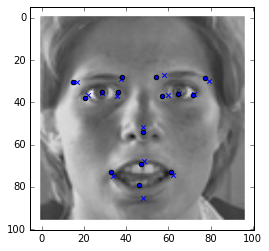

In [202]:
img_id = 1010
plt.imshow(X_train[img_id,0],cmap='gray')
plt.scatter(y_train[img_id,0::2],y_train[img_id,1::2],marker='x')
plt.scatter(Y_decode[img_id,0::2],Y_decode[img_id,1::2],marker='o')

Fit to Y_code. Does not work due to 1) Y_code does not recover y_train very well. 2) net could not fit Y_code very well

In [288]:
def build_model5():
    net = {}
    net['input'] = InputLayer((7, 256, 12, 12))
    net['conv4_1'] = rrelu(ConvLayer(net['input'], 512, 3, pad=1))
    net['conv4_2'] = rrelu(ConvLayer(net['conv4_1'], 512, 3, pad=1))
    net['conv4_3'] = rrelu(ConvLayer(net['conv4_2'], 512, 3, pad=1))
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = rrelu(ConvLayer(net['pool4'], 512, 3, pad=1))
    net['conv5_2'] = rrelu(ConvLayer(net['conv5_1'], 512, 3, pad=1))
    net['conv5_3'] = rrelu(ConvLayer(net['conv5_2'], 512, 3, pad=1))
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=100,nonlinearity=lasagne.nonlinearities.very_leaky_rectify)
    net['fc7'] = DenseLayer(net['fc6'], num_units=5,nonlinearity=lasagne.nonlinearities.very_leaky_rectify)
    return net

In [289]:
net_model2 = build_model5()

In [290]:
X_tt = tt.tensor4()
y_tt = tt.matrix()
learning_rate_tt = tt.scalar()
m_tt = tt.scalar()

In [291]:
out = layers.get_output(net_model2['fc7'],X_tt)

In [292]:
cost = tt.sum( (y_tt - out)**2 )

In [293]:
paras = lasagne.layers.get_all_params(net_model2['fc7'], trainable=True) 

In [294]:
gparas = [tt.grad(cost,para) for para in paras]
vparas = [theano.shared(np.zeros(para.get_value().shape,dtype='float32')) for para in paras]

In [295]:
updates=[]
for p,g,v in zip(paras,gparas,vparas):
    updates.append((v,m_tt*v - learning_rate_tt*g))
    updates.append((p,p+m_tt*m_tt*v-(1+m_tt)*learning_rate_tt*g))

In [296]:
#updates = lasagne.updates.nesterov_momentum(
#            cost, paras, learning_rate=learning_rate_tt, momentum=m_tt)

In [297]:
train_fn = theano.function([X_tt, y_tt,learning_rate_tt,m_tt], cost, updates=updates)

In [298]:
#predict  = theano.function([X_tt],out)

In [299]:
loss = theano.function([X_tt, y_tt], cost)

In [285]:
err_base = np.sum((Y_code - Y_code.mean(0))**2)

In [300]:
epoch = 10

for i in range(epoch):
    for j in range(n/batch_size):
        train_fn(X_feature[j * batch_size: (j + 1) * batch_size], \
                 Y_code[j * batch_size: (j + 1) * batch_size],\
                 1e-8, 0.95)
        

    err = 0
    for j in range(n/batch_size):
        err += loss(X_feature[j * batch_size: (j + 1) * batch_size], \
                 Y_code[j * batch_size: (j + 1) * batch_size])
    
    
    print 'epoch:{}, err:{}'.format(i,err/err_base)

epoch:0, err:1.51610684573
epoch:1, err:1.45878960094
epoch:2, err:1.44076989905
epoch:3, err:1.37921427683
epoch:4, err:1.38271155059
epoch:5, err:1.37879740084
epoch:6, err:1.38850073782
epoch:7, err:1.34391978169
epoch:8, err:1.33953258596
epoch:9, err:1.35620368092


<a id='predict'></a>
** Make prediction for test dataset **

In [1034]:
X_test = pd.read_csv(r'/home/will/Desktop/data/Facial Keypoints Detection/test.csv')

In [1035]:
X_test = X_test.Image.str.split(expand=True).values.astype('float32')

In [1036]:
n_test = X_test.shape[0]

In [1037]:
X_test = scaler.transform(X_test).reshape(n_test,1,96,96)

In [1038]:
X_test = np.broadcast_to(X_test , (n_test,3,96,96))

In [1039]:
X_test2 = np.zeros((n_test, 256, 12, 12),dtype='float32')
for i in range(n_test//batch_size+1):
    X_test2[i * batch_size: min(n_test,(i + 1) * batch_size)] = \
        feature_ext(X_test[i * batch_size: min(n_test,(i + 1) * batch_size)])

In [1040]:
X_test2 = (X_test2- feature_mean)/feature_std 

In [1041]:
X_test = X_test[:,0,:,:]

In [944]:
X_test = pad(X_test,((0,0),(7,7),(7,7)),'constant',constant_values=.0)

In [268]:
# model1
y_test = np.zeros((n_test,30))

for i in range(n_test//batch_size+1):
    y_test[i * batch_size: min(n_test,(i + 1) * batch_size)] = \
        predict(X_test2[i * batch_size: min(n_test,(i + 1) * batch_size)])

In [1042]:
# model2 & 3
# repeat 10 times to average out the randomness in model 
y_test = np.zeros((n_test,30))
for j in range(10):
    for i in range(n_test//batch_size+1):
        y_test[i * batch_size: min(n_test,(i + 1) * batch_size)] += \
            predict(X_test2[i * batch_size: min(n_test,(i + 1) * batch_size)],\
                    group_label_test[i * batch_size: min(n_test,(i + 1) * batch_size)])
y_test /= 10

In [1047]:
y_test_final = np.where(np.logical_or(y_test2==0,np.isnan(y_test2)), y_test,y_test2)

In [947]:
# model 6, run model 2&3 first
for (ind1,ind2),model in zip(index_list,add_model_list):
    X_crop = np.zeros((n_test,14*14))
    for i,(x,y) in enumerate(np.rint(y_test[:,ind1:ind2])):
        X_crop[i,:] = crop(X_test[i],((y,96-y),(x,96-x))).reshape(14*14)
    y_test[:,ind1:ind2]+=model.predict(X_crop)

In [951]:
y_test_pd = pd.DataFrame(y_test,range(1,n_test+1),IdLookupTable.FeatureName[0:30].values).stack()

In [1048]:
y_test_pd = pd.DataFrame(y_test_final,range(1,n_test+1),IdLookupTable.FeatureName[0:30].values).stack()

In [1049]:
IdLookupTable.merge(y_test_pd.reset_index(),\
                    left_on=['ImageId','FeatureName'],right_on=['level_0','level_1'])\
             .drop(['Location'],1).rename(index=str, columns={0: "Location"})\
             .loc[:,['RowId','Location']]\
             .to_csv(r'/home/will/Desktop/data/Facial Keypoints Detection/model6.csv',index=False)